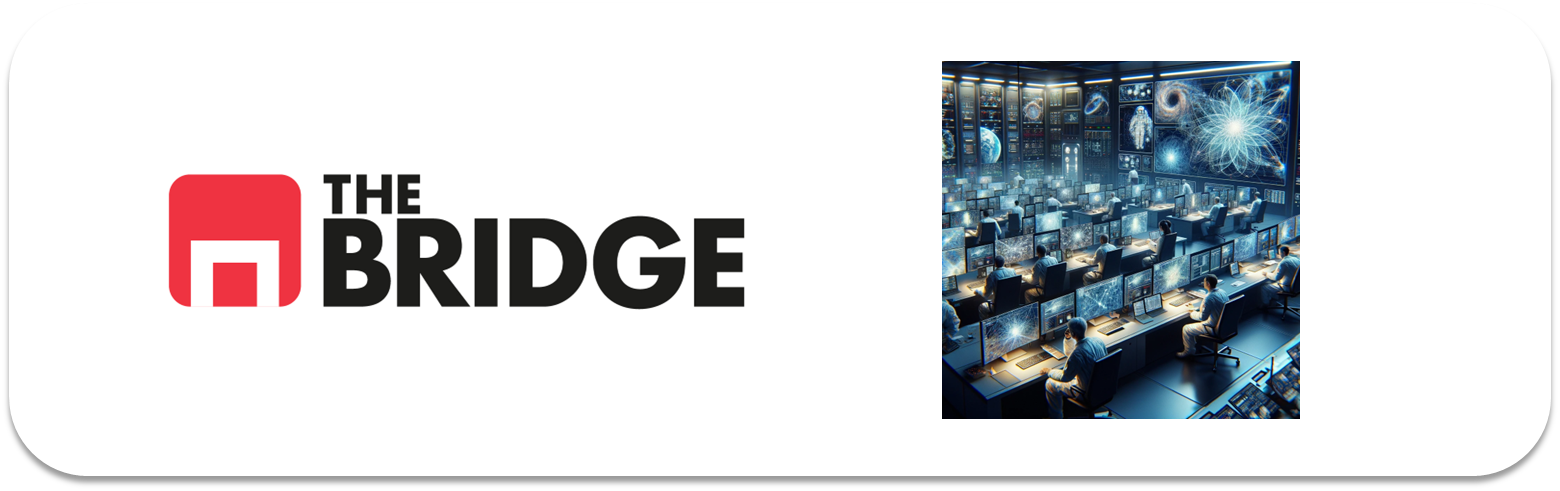

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.applications import InceptionV3
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from skimage.io import imread

import cv2
import os

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_data(directorio, reshape_dim = (299,299)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 299x299

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

def plot_image(i, class_predicted, class_prob, true_label, img):
  img = img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  plt.xlabel(f"{class_predicted} {class_prob:.2f} ({true_label})")

def plot_value_array(predictions_array, predictions_labels):
  #predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(len(predictions_labels)),labels = predictions_labels)
  plt.yticks([])
  thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  plt.xlabel("top-5 predicciones")

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [4]:
# Paths
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + 'seg_train/'
TEST_PATH = ROOT_PATH + 'seg_test/'

# Carga de datos
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

print('\nX_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape, end = '\n\n')
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (14034, 299, 299, 3)
y_train.shape: (14034,)

X_test.shape: (3000, 299, 299, 3)
y_test.shape: (3000,)


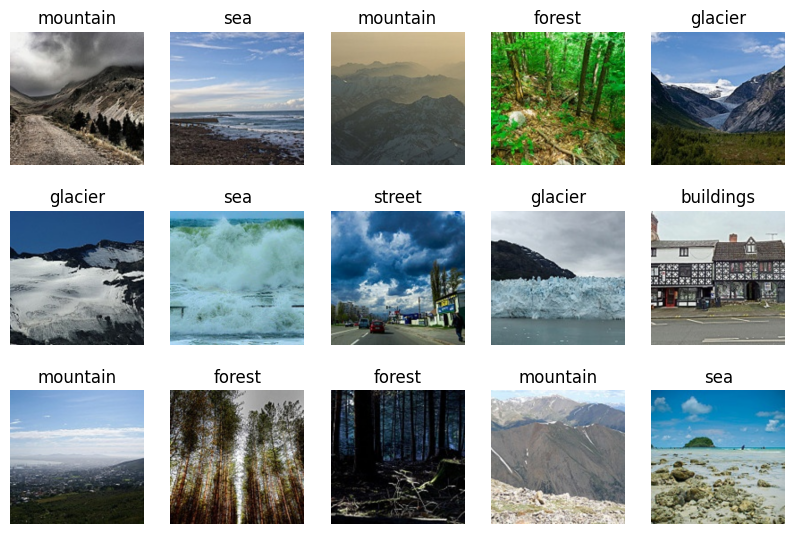

In [5]:
# Visualización imágenes

indices = np.random.randint(0, len(X_train), 15)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [6]:
# Proporciones del target

targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [7]:
# Normalización
X_train = X_train / 255
X_test = X_test / 255

# Label Encoder de target
lab_enc = LabelEncoder()
y_train_num = lab_enc.fit_transform(y_train)
y_test_num = lab_enc.transform(y_test)

# Shuffle (Aleatorización de datos)
X_train_Shuffle, y_train_Shuffle = shuffle(X_train, y_train_num)

MemoryError: Unable to allocate 28.0 GiB for an array with shape (14034, 299, 299, 3) and data type float64

In [8]:
# Cargar InceptionV3 sin la capa de clasificación final
base_model_tl = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
# InceptionV3 usa imágenes de 299x299, así que si se usan imágenes más pequeñas (ej. 224x224), debes redimensionarlas antes de entrenar.

# Congelar las capas preentrenadas
base_model_tl.trainable = False  

# Construcción del modelo
model = keras.Sequential([
    base_model_tl,
    keras.layers.Flatten(),  # Convertir en vector 1D
    keras.layers.Dense(512, activation="relu"),  # Capa densa con 512 neuronas
    keras.layers.Dropout(0.5),  # Dropout del 50%
    keras.layers.Dense(6, activation="softmax")  # Capa de salida para 6 clases
])

# Compilar el modelo
model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

# Resumen del modelo
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,915,238 (339.18 MB)

 Trainable params: 67,112,454 (256.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [9]:
# Definir el EarlyStopping
earlys = keras.callbacks.EarlyStopping(monitor='val_loss',  # Monitorea la pérdida en validación
                                       patience=5,          # Espera 5 épocas sin mejora antes de detenerse
                                       restore_best_weights=True)  # Restaura los mejores pesos

# Entrenar el modelo con Early Stopping
history = model.fit(X_train_Shuffle, 
                    y_train_Shuffle, 
                    batch_size=64, 
                    validation_split=0.2,
                    epochs=40, 
                    callbacks=[earlys]  # Agregar el callback
)

NameError: name 'X_train_Shuffle' is not defined

In [10]:
model.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.2297 - loss: 2.3204


[1.9574204683303833, 0.25999999046325684]

In [11]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step


In [12]:
# Convertir las predicciones numéricas de vuelta a etiquetas de texto
y_pred_text = lab_enc.inverse_transform(y_pred)

# Ahora puedes generar el reporte de clasificación
print(classification_report(y_test, y_pred_text))

              precision    recall  f1-score   support

   buildings       0.07      0.00      0.00       437
      forest       0.23      0.70      0.35       474
     glacier       0.10      0.02      0.03       553
    mountain       0.38      0.48      0.43       525
         sea       0.22      0.11      0.15       510
      street       0.24      0.25      0.25       501

    accuracy                           0.26      3000
   macro avg       0.21      0.26      0.20      3000
weighted avg       0.21      0.26      0.20      3000



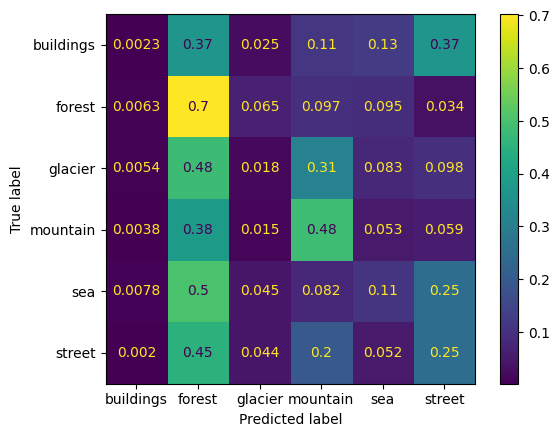

In [13]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_text, normalize="true")
plt.show()

In [14]:
for indice, layer in enumerate(model.layers):
    print("Capa %d: %s" %(indice, layer.name))

Capa 0: inception_v3
Capa 1: flatten
Capa 2: dense
Capa 3: dropout
Capa 4: dense_1


In [15]:
# Cargar InceptionV3 sin la capa de clasificación final
base_model_ft = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# Descongelar algunas capas del modelo base (por ejemplo, las últimas 10 capas)
for layer in base_model_ft.layers[-10:]:
    layer.trainable = True

# Construcción del modelo
model = keras.Sequential([
    base_model_ft,
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation="softmax")
])

# Compilar el modelo
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Usar un learning rate bajo para fine-tuning
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

# Resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,915,238 (339.18 MB)

 Trainable params: 88,880,806 (339.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [16]:
# Definir el EarlyStopping
earlys = keras.callbacks.EarlyStopping(monitor='val_loss',  # Monitorea la pérdida en validación
                                       patience=5,          # Espera 5 épocas sin mejora antes de detenerse
                                       restore_best_weights=True)  # Restaura los mejores pesos

# Entrenar el modelo con Early Stopping
history = model.fit(X_train_Shuffle, 
                    y_train_Shuffle, 
                    batch_size=64, 
                    validation_split=0.2,
                    epochs=40, 
                    callbacks=[earlys]  # Agregar el callback
)

NameError: name 'X_train_Shuffle' is not defined

In [17]:
model.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.1203 - loss: 2.2237


[2.0582072734832764, 0.18833333253860474]

In [18]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step


In [19]:
# Convertir las predicciones numéricas de vuelta a etiquetas de texto
y_pred_text = lab_enc.inverse_transform(y_pred)

# Ahora puedes generar el reporte de clasificación
print(classification_report(y_test, y_pred_text))

              precision    recall  f1-score   support

   buildings       0.18      0.03      0.05       437
      forest       0.05      0.05      0.05       474
     glacier       0.20      0.35      0.25       553
    mountain       0.18      0.06      0.09       525
         sea       0.23      0.56      0.33       510
      street       0.34      0.03      0.05       501

    accuracy                           0.19      3000
   macro avg       0.20      0.18      0.14      3000
weighted avg       0.20      0.19      0.14      3000



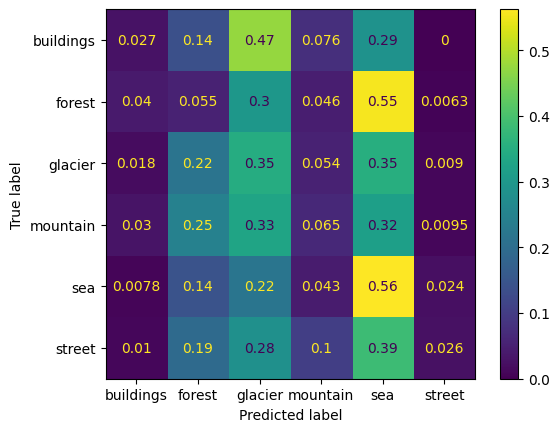

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_text, normalize="true")
plt.show()